# Style transfer

In this tutorial, we will create and train a neural model for style transfer. It's a computer vision method used for reproducing an image (so-called content image) with style features of another one (so-called, reference image). With neural style transfer, it becomes possible to imitate painting techniques of famous artists.

We will train our neural network on the famous [COCO dataset](http://cocodataset.org/#home) that contains images of different objects.

# Install libraries

First, we need to prepare our work environment and install the necessary Python packages. If you're using Google Colab, you already have them, and you can skip next cell.

We added strict version requirements for the packages for better reproducibility.

Note that these versions of packages will replace already installed ones.

In [4]:
%pip install -q onnx

if 'google.colab' in str(get_ipython()):
    print('Skipping pip installation on Google Colab')
else:
    %pip install -q numpy==1.18.2 opencv-python-headless==4.2.0.32 \
        torch==1.4.0 torchvision==0.5.0 folium==0.2.1 \
        albumentations==0.4.5 tqdm==4.43.0 matplotlib==3.2.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 85.0 MB/s eta 0:00:00
Skipping pip installation on Google Colab


# Import libraries

Let's import the libraries we will use in the project.

In [5]:
from itertools import islice
from pathlib import Path
import random
import urllib.request
from zipfile import ZipFile

import albumentations as albm
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils import data
from torch.nn.utils import spectral_norm
import torchvision
from tqdm.notebook import tqdm

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


For better reproducibility, it would be useful to set random seeds for the libraries.

In [6]:
RANDOM_SEED = 123

random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Flip values for slower training speed, but more determenistic results.
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

It's recommended to train neural networks on GPU. However, it's possible to train them on a CPU as well. We will use the 0th GPU (`cuda:0`) if a GPU is available and CPU otherwise.

In [7]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device:', DEVICE)

device: cpu


# Global variables for training

This training notebook uses [COCO dataset](http://cocodataset.org/). The annotations in this dataset belong to the COCO Consortium and are [licensed](http://cocodataset.org/#termsofuse) under a Creative Commons Attribution 4.0 License. Images are part of Flickr and have corresponding licenses. To check license for each image please refer to [the image information](http://images.cocodataset.org/annotations/image_info_unlabeled2017.zip).

Let's set the parameters of the dataset and the training process.

In [8]:
COCO_CATEGORY = 'person'  # target category

WORK_DIR = Path('.')

# Archives to be downloaded
COCO_IMAGES_ARCHIVE = WORK_DIR / 'train2017.zip'
COCO_ANNOTATIONS_ARCHIVE = WORK_DIR / 'annotations_trainval2017.zip'

# Paths where the dataset will be extracted to
COCO_ANNOTATIONS_PATH = WORK_DIR / 'annotations/instances_train2017.json'
COCO_IMAGES_PATH = WORK_DIR / 'train2017'

# How many images use for training
DATASET_SIZE = 32000

# A content and a style images. You can upload your own.
TEST_IMAGE_PATH = WORK_DIR / 'test_image.png'
STYLE_IMAGE_PATH = WORK_DIR / 'style_image.png'

NUM_TRAINING_STEPS = 10000  # number of steps for training, longer is better
LOGGING_FREQUENCY = 250     # log validation every N steps
BATCH_SIZE = 16             # number of images per batch
NUM_WORKERS = 4             # number of CPU threads available for image preprocessing

# This controls input and output resolution for the network.
# Lower values lead to worse mask quality, but faster network inference.
# Change carefully.
INPUT_HEIGHT = 512
INPUT_WIDTH = 256

# Base number of channels for model. Higher is stronger effect, but slower model
MODEL_WIDTH = 16

In [9]:
LR = 0.01                    # Initial learning rate
LR_DECREASING_FACTOR = 0.1   # Factor of decreasing LR by a scheduler
WEIGHT_DECAY = 0.0001        # Weight decaying coefficient

In [10]:
ONNX_PATH = './style_new.onnx'

The constants below are the weights of the loss functions' components. You can change it for tuning style-identity tradeoff.

In [11]:
STYLE_WEIGHT = 1e6              # How strong style should be forced
RECONSTRUCTION_WEIGHT = 5e-3    # How strong identity image will be preserved
CONSISTENCY_WEIGHT = 5e-3       # As larger value more stable network will be, but weaker effect

Colab's GPU runtimes don't have enough free drive space to store the entire COCO dataset, so we'll have to unpack only the files that we need for training.

First of all, we have to download the archives with images and annotations. For convenience, we can use the functions below. It downloads a file but only if we have not already downloaded it.

In [12]:
def download_file(link, filename):
    if Path(filename).exists():
        return
    progress_bar = tqdm(desc=str(filename),
                        dynamic_ncols=True, leave=False,
                        mininterval=5, maxinterval=30,
                        unit='KiB', unit_scale=True,
                        unit_divisor=1024)

    def update_progress(count, block_size, total_size):
        if progress_bar.total is None:
            progress_bar.reset(total_size)
        progress_bar.update(count * block_size - progress_bar.n)

    urllib.request.urlretrieve(link, filename, reporthook=update_progress)
    urllib.request.urlcleanup()
    progress_bar.close()

Now we can download archives with images and annotations, and extract the data we need from them. If you encounter message "Disk is almost full" on Google Colab, please click the "ignore" button.

In [13]:
download_file('http://images.cocodataset.org/zips/train2017.zip',
              COCO_IMAGES_ARCHIVE)

download_file('http://images.cocodataset.org/annotations/annotations_trainval2017.zip',
              COCO_ANNOTATIONS_ARCHIVE)
with ZipFile(COCO_ANNOTATIONS_ARCHIVE, 'r') as archive:
    archive.extractall()

train2017.zip: 0.00KiB [00:00, ?KiB/s]

annotations_trainval2017.zip: 0.00KiB [00:00, ?KiB/s]

An image ID is a 12-digits number padded with zeros. The name of every image inside the archive with images is an image ID with the `.jpg` extension. We can extract all the IDs by listing the archive and getting the names of images.

In [14]:
with ZipFile(COCO_IMAGES_ARCHIVE) as archive:
    coco_images_list = archive.namelist()
all_ids = [int(Path(name).stem) for name in coco_images_list[1:]]

Now we will sample a fraction of training examples.

In [15]:
train_img_ids = random.sample(all_ids, min(len(all_ids), DATASET_SIZE))
random.shuffle(train_img_ids)

Now we will extract only the images that we need for training since COCO is pretty large.

In [16]:
# Prepare a directory for the images
COCO_IMAGES_PATH.mkdir(exist_ok=True, parents=True)

with ZipFile(COCO_IMAGES_ARCHIVE, 'r') as archive:
    for image_id in tqdm(train_img_ids, dynamic_ncols=True, leave=False, mininterval=5, maxinterval=30):
        image_name = str(image_id).zfill(12) + '.jpg'
        image_path = Path('train2017') / image_name

        if Path(image_path).exists():
            continue
        archive.extract(str(image_path), WORK_DIR)

        # resize for faster loading time
        image = cv2.imread(str(image_path))
        scaled_width = int(INPUT_HEIGHT * image.shape[1] / image.shape[0])
        image = cv2.resize(image, (scaled_width, INPUT_HEIGHT),
                        interpolation=cv2.INTER_LINEAR)
        cv2.imwrite(str(image_path), image)

  0%|          | 0/32000 [00:00<?, ?it/s]

Let's also load an image that we'll use to check the quality of the Style Transfer while we train the network.

In [17]:
test_img_bgr = cv2.imread(str(TEST_IMAGE_PATH))
TEST_IMG = cv2.cvtColor(test_img_bgr, cv2.COLOR_BGR2RGB)

Let's take a look at our test image.

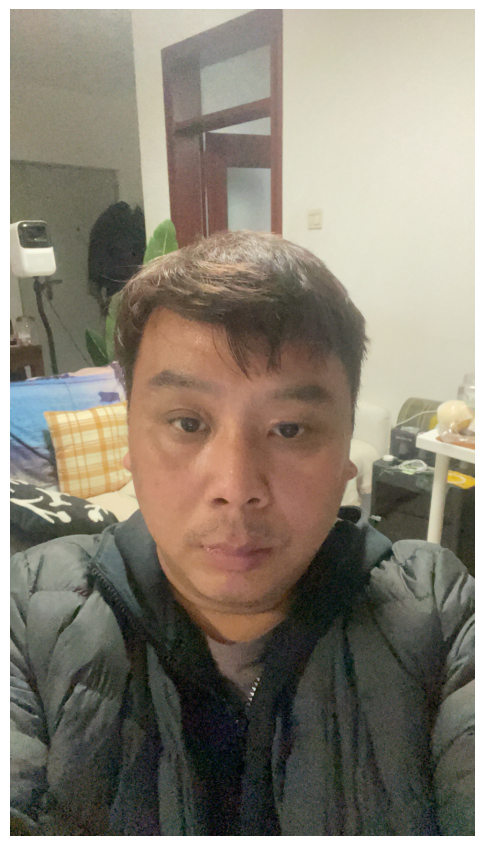

In [18]:
plt.figure(figsize=(6, 12))
plt.imshow(TEST_IMG)
plt.axis('off')
plt.show()

# Model

Now we can describe the model we will use for style transfer. We will build the model from mainly two types of blocks: residual hourglass-like blocks and separable residual ones.

Separable residual block. The main idea of separable blocks is splitting a convolution to two parts: a channel-wise and a depth-wise one. They are used widely in architectures like MobileNet and Inception for reducing computational costs.

In [19]:
class ResidualSep(nn.Module):
    def __init__(self, channels, dilation=1):
        super().__init__()

        self.blocks = nn.Sequential(
            nn.ReLU(),
            nn.ReflectionPad2d(dilation),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1,
                      padding=0, dilation=dilation,
                      groups=channels, bias=False),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=1, stride=1,
                      padding=0, bias=False),
            nn.BatchNorm2d(channels)
        )

    def forward(self, x):
        return x + self.blocks(x)

The residual hourglass-like blocks is a residual blocks with downsampling.

In [20]:
class ResidualHourglass(nn.Module):
    def __init__(self, channels, mult=0.5):
        super().__init__()

        hidden_channels = int(channels * mult)

        self.blocks = nn.Sequential(
            nn.ReLU(),
            # Downsample
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, hidden_channels, kernel_size=3, stride=2,
                      padding=0, dilation=1,
                      groups=1, bias=False),
            nn.BatchNorm2d(hidden_channels),
            # Bottleneck
            ResidualSep(channels=hidden_channels, dilation=1),
            ResidualSep(channels=hidden_channels, dilation=2),
            ResidualSep(channels=hidden_channels, dilation=1),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(hidden_channels, channels, kernel_size=3, stride=1,
                      padding=0, dilation=1,
                      groups=1, bias=False),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True),
            # Upsample
            nn.ConvTranspose2d(channels, channels, kernel_size=2, stride=2,
                               padding=0, groups=1, bias=True),
            nn.BatchNorm2d(channels)
        )

    def forward(self, x):
        return x + self.blocks(x)

Now we have all the blocks needed for building the model, and we can write a class for it. Note the normalization at the end of the initializer. We are going to pass image tensors with pixel values from a wide range so that we have to initialize the weights of the convolutions with smaller values.

In [21]:
class TransformerNet(torch.nn.Module):
    def __init__(self, width=8):
        super().__init__()

        self.blocks = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(3, width, kernel_size=3, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(width, affine=True),
            ResidualHourglass(channels=width),
            ResidualHourglass(channels=width),
            ResidualSep(channels=width, dilation=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(width, 3, kernel_size=3, stride=1, padding=1, bias=True)
        )

        # Normalization
        self.blocks[1].weight.data /= 127.5
        self.blocks[-1].weight.data *= 127.5 / 8
        self.blocks[-1].bias.data.fill_(127.5)

    def forward(self, x):
        return self.blocks(x)

# Dataset

The class below specifies image loading and augmentations to add variety to our dataset and increase network stability to different input conditions.

A dataset is an iterator-like object that returns an image and its label at every step. A loader is an object that aggregates the output of the dataset and returns batches.

The dataset object is pretty simple. It loads an image from disk and applies the transforms to it. It returns a transformed image and the corresponding label.

In [22]:
class CocoDataset(data.Dataset):
    def __init__(self, image_folder, image_list, augmentations):
        self.image_folder = Path(image_folder)
        self.image_list = image_list
        self.augmentations = augmentations

    def __getitem__(self, item):
        image_id = self.image_list[item]
        image_path = self.image_folder / (str(image_id).zfill(12) + '.jpg')
        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        scale = INPUT_HEIGHT / image.shape[0]
        image = cv2.resize(image, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
        augmented = self.augmentations(image=image)
        image = augmented['image'].astype('float32')
        return {'image': image.transpose(2, 0, 1)}

    def __len__(self):
        return len(self.image_list)

We will use augmentation to extend the dataset and increase its diversity.

In [23]:
train_augmentations = albm.Compose([
    albm.PadIfNeeded(min_height=INPUT_HEIGHT, min_width=INPUT_WIDTH, always_apply=True),
    albm.RandomCrop(height=INPUT_HEIGHT, width=INPUT_WIDTH, always_apply=True),
    albm.RandomBrightnessContrast(),
    albm.HorizontalFlip()
])

Let's create a dataset and a data loader objects.

In [24]:
train_dataset = CocoDataset(COCO_IMAGES_PATH, train_img_ids,
                            train_augmentations)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                           num_workers=NUM_WORKERS, drop_last=True,
                                           shuffle=True,
                                           worker_init_fn=lambda _: np.random.seed())

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


For convenience let's create a function for displaying images.

In [25]:
def show(img, nrow=8, interpolation='nearest'):
    img = torch.clamp(img / 255.0, 0.0, 1.0)
    img_grid = torchvision.utils.make_grid(img, nrow=nrow).numpy()
    plt.figure(figsize=(12, 12))
    plt.imshow(np.transpose(img_grid, (1, 2, 0)), interpolation=interpolation)
    plt.axis('off')
    plt.show()

Also we will use a function for loading an image and converting it to a PyTorch tensor that is ready to be passed into the model.

In [26]:
def image_to_batch(image_name):
    image = cv2.imread(str(image_name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    scale = INPUT_HEIGHT / image.shape[0]
    image = cv2.resize(image, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
    image = image.astype('float32').transpose(2, 0, 1)
    batch = torch.from_numpy(image).unsqueeze(0)
    return batch

Let's test these two functions.

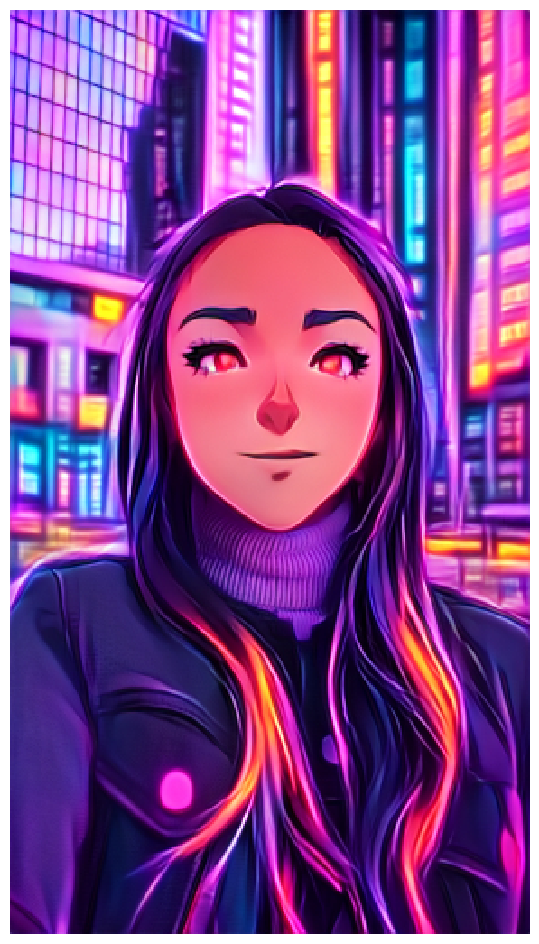

In [27]:
style_img = image_to_batch(STYLE_IMAGE_PATH)
style_img = style_img.to(device=DEVICE)
show(style_img.cpu(), nrow=4)

# Auxiliary functions and models

One of the most important parts of style transfer loss function is a so-called [Gram (of Gramian) matrix](https://en.wikipedia.org/wiki/Gramian_matrix). Its purpose is to remove spatial information remaining the style. You can find the details of the approach in the paper [*Johnson et al.* Perceptual Losses for Real-Time Style Transfer and Super-Resolution](https://arxiv.org/abs/1603.08155).


We can write functions for computing Gram matrices.

In [28]:
def gram_matrix(y):
    (bn, ch, h, w) = y.size()
    features = y.transpose(0, 1).contiguous()
    features = features.view(ch, w * h * bn)
    features_t = features.transpose(0, 1)
    gram = features.mm(features_t) / (ch * h * w * bn)
    return gram

For computing the perceptual loss function we have to use a pretrained convolutional neural network. Following the papers on style transfer we will use pretrained VGG16.

In [29]:
class Vgg16(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super().__init__()
        vgg_pretrained_features = torchvision.models.vgg16(pretrained=True).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

        self.slices = [self.slice1, self.slice2, self.slice3, self.slice4]

    def forward(self, x, features_num=4):
        # Normalize according to VGG inputs
        mean = x.new_tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
        std = x.new_tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
        h = (x / 255.0 - mean) / std

        # Compute features
        ret = []
        for i in range(features_num):
            h = self.slices[i](h)
            ret.append(h)
        return ret

Let's initialize our feature extraction model and compute Gram matrix for style image features.

In [30]:
vgg = Vgg16(requires_grad=False).to(device=DEVICE)
features_style = vgg(style_img)
gram_style = [(gram_matrix(y).detach()) for y in features_style]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 90.5MB/s]


# Optimizer setup

Here we set up training and model itself.

In [31]:
model = TransformerNet(width=MODEL_WIDTH)
model = model.to(device=DEVICE)

We'll also set up a learning rate scheduler to drop learning rate if our network training process reaches a plateau.

In [32]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',
                                                       factor=LR_DECREASING_FACTOR, patience=2,
                                                       verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


This helper function will display image and network output side by side to see the progress during training

In [33]:
def show_test_image_quality(model, image):
    scale = min(
        INPUT_HEIGHT / image.shape[0],
        INPUT_WIDTH / image.shape[1])

    image = cv2.resize(image, None,
                       fx=scale, fy=scale,
                       interpolation=cv2.INTER_CUBIC)

    off_h = INPUT_HEIGHT - image.shape[0]
    off_w = INPUT_WIDTH - image.shape[1]

    model_input = torch.tensor(image.astype('float32').transpose(2, 0, 1))
    model_input = F.pad(model_input, (off_w, 0, off_h, 0))

    plt.subplot(121)
    plt.imshow(image)
    plt.axis('off')
    plt.title('input')

    with torch.no_grad():
        model_input = model_input.unsqueeze(0).to(DEVICE)
        model_output = model(model_input)
    output = model_output[0]
    output = torch.clamp(output / 255.0, 0, 1)
    output = output.cpu().numpy().transpose(1, 2, 0)
    output = output[off_h:, off_w:, :]

    plt.subplot(122)
    plt.imshow(output)
    plt.axis('off')
    plt.title('output')

    plt.tight_layout()
    plt.show()

Let's check the function with a fake identity model.

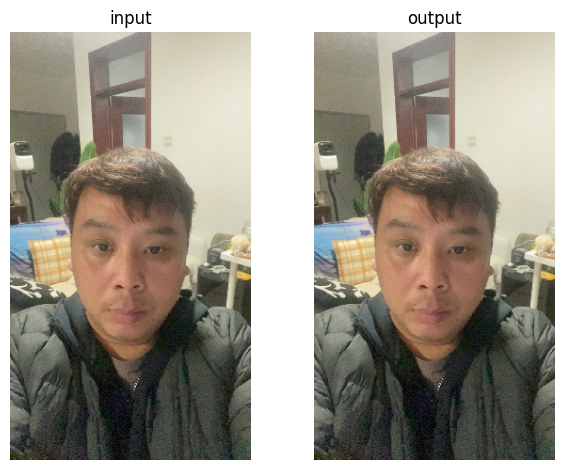

In [34]:
show_test_image_quality(lambda x: x, TEST_IMG)

# Train loop

For cycling the dataloader into an infinite batch generator we can use the following simple function. Then we can take from this generator any batches we need with standard `itertools.islice` function.

In [35]:
def cycle(it):
    while True:
        yield from it

Now we can run the main training loop.

In [ ]:
train_loss = None
ema_alpha = 0.05

pbar = tqdm(islice(cycle(train_loader), NUM_TRAINING_STEPS),
            dynamic_ncols=True, leave=False, mininterval=5, maxinterval=30,
            desc='Training', total=NUM_TRAINING_STEPS)
for batch_num, batch in enumerate(pbar):
    model.train()
    optimizer.zero_grad()

    image = batch['image'].to(DEVICE)

    noise = torch.zeros_like(image)
    noise.normal_(mean=0, std=4)
    styled_image = model(image + noise)

    features_x = vgg(image, features_num=2)
    features_y = vgg(styled_image)

    content_loss = F.mse_loss(features_y[1], features_x[1])

    # Compute style loss
    style_loss = 0.
    idx = 1
    for ft_y, gm_s in zip(features_y, gram_style):
        gm_y = gram_matrix(ft_y)
        style_loss += F.mse_loss(gm_y, gm_s) * idx / gm_y.shape[1]
        idx *= 2

    # Compute consistency loss
    dx = random.choice([-3,-2,-1,1,2,3])
    dy = random.choice([-3,-2,-1,1,2,3])
    image_shifted = torch.roll(image, shifts=(dx, dy), dims=(2, 3))

    noise.normal_(mean=0, std=4)
    styled_image_shifted = model(image_shifted + noise)
    styled_image_shifted = torch.roll(styled_image_shifted, shifts=(-dx, -dy), dims=(2, 3))
    consistency_loss = F.mse_loss(styled_image_shifted[:,:,4:-4,4:-4], styled_image[:,:,4:-4,4:-4])

    loss_value = style_loss * STYLE_WEIGHT \
                 + content_loss * RECONSTRUCTION_WEIGHT \
                 + consistency_loss * CONSISTENCY_WEIGHT

    pbar.set_postfix({
        'Loss': f'{loss_value.item():.3f}',
        'Style (×10⁶)': f'{style_loss.item() * 1e6:.3f}',
        'Content': f'{content_loss.item():.3f}',
        'Consistency': f'{consistency_loss.item():.3f}'
    }, refresh=False)

    loss_value.backward()
    optimizer.step()

    if train_loss is None:
        train_loss = loss_value.item()
    else:
        train_loss = ema_alpha * loss_value.item() + (1 - ema_alpha) * train_loss

    if batch_num % LOGGING_FREQUENCY == 0:
        print(f'[{batch_num}] train \t loss: {train_loss:.5f}')
        scheduler.step(train_loss)

        model.eval()
        show_test_image_quality(model, TEST_IMG)

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

# Export

It's time to convert our model to a universal format ONNX so that the model can be used in a lens.

In [ ]:
model.eval()
dummy_input = torch.randn(1, 3, INPUT_HEIGHT, INPUT_WIDTH,
                          dtype=torch.float32, device=DEVICE)

output = model(dummy_input.detach())

input_names = ['data']
output_names = ['output1']

torch.onnx.export(model, dummy_input,
                  ONNX_PATH, verbose=False,
                  input_names=input_names, output_names=output_names, opset_version=10)

If you use Google Colab you can download the model with the following code.

In [ ]:
def download_onnx_from_colab():
    from google.colab import files
    files.download(ONNX_PATH)

## Uncomment for downloading ONNX from Colab
# download_onnx_from_colab()